In [27]:
import numpy as np

from tangelo import SecondQuantizedMolecule as SQMol
from tangelo.linq import Circuit, Gate, get_backend
from tangelo.toolboxes.operators import QubitOperator
from tangelo.toolboxes.circuits.qsp import get_qsp_hamiltonian_simulation_circuit, get_qsp_hamiltonian_simulation_qubit_list
from tangelo.toolboxes.ansatz_generator.ansatz_utils import trotterize
from tangelo.toolboxes.qubit_mappings.statevector_mapping import do_scbk_transform
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping as f2q_mapping
from tangelo.toolboxes.qubit_mappings.statevector_mapping import vector_to_circuit
li2=  """Li 0.  0. 0.
         Li 3.0 0. 0. """

# 2 electrons in 2 orbitals
fo = [0,1]+[i for i in range(4,28)]

# Runs RHF calculation
mol_Li2 = SQMol(li2, q=0, spin=0, basis='6-31g(d,p)', frozen_orbitals=fo, symmetry=True)
h_obj =  f2q_mapping(mol_Li2.fermionic_hamiltonian, "scbk", mol_Li2.n_active_sos,
                     mol_Li2.n_active_electrons, up_then_down=True, spin=mol_Li2.spin)
# Stretch factor of 300 to make eigenvalue gap larger. Therefore, time evolution needs to be shorter.
h_obj = 300*(h_obj - QubitOperator((), -14.85))
n_qubits = 2#len(get_qsp_hamiltonian_simulation_qubit_list(h_obj))
print(n_qubits)


2


In [110]:
# One rodeo cycle as defined in Fig.1 of arXiv.2110.07747
def rodeo_cycle(hobj, energy, t, i):
    circuit = Circuit([Gate("H", i)])
    circuit += trotterize(hobj, time=t, control=i, trotter_order=4, n_trotter_steps=6)
    circuit += Circuit([Gate("PHASE", i, parameter=energy*t), Gate("H", i)])
    return circuit

In [90]:


sim = get_backend()

sigma = 0.4

# We will use multiple reference states as probability depends on overlap with starting state.
ref_states = [vector_to_circuit(do_scbk_transform([1, 1, 0, 0], 4)),
              vector_to_circuit(do_scbk_transform([1, 0, 1, 0], 4)),
              vector_to_circuit(do_scbk_transform([0, 0, 1, 1], 4))]

# Equivalent to energies from -14.9 -> 14.75 for 10 iterations.
energies = [-0.05*300 +300*0.005*i for i in range(30)]
success_prob = list()
for energy in energies:
    success=0
    for sample in range(40):
        t = np.random.normal(0, sigma, 4)
        cstart = np.random.choice(ref_states)
        sv = np.zeros(2**(n_qubits+1))
        sv[0] = 1
        c_success = 1
        for i, tk in enumerate(t):
            if i == 0:
                circuit = cstart + rodeo_cycle(h_obj, energy, tk, n_qubits)
            else:
                circuit = rodeo_cycle(h_obj, energy, tk, n_qubits)
            _, sv = sim.simulate(circuit, return_statevector=True, initial_statevector=sv)
            sv = np.reshape(sv, (2, 2**n_qubits))[0, :].flatten()
            norm = np.linalg.norm(sv)
            c_success *= norm**2
            sv /= norm
            sv = np.kron([1,0], sv)
            
        #print(sim.mid_circuit_meas_freqs)
        success += c_success
    success_prob.append(success/40)
    print(energy, success/40)


-15.0 0.04889911706453975
-13.5 0.07383494659955121
-12.0 0.06765053883083393
-10.5 0.08257786221888881
-9.0 0.22009543645345775
-7.5 0.2748450390791964
-6.0 0.3428121238866467
-4.5 0.25624178174436296
-3.0 0.1648711724097951
-1.5 0.07676487811963659
0.0 0.13950849086476685
1.5 0.2702871764384635
3.0 0.3845132440155378
4.5 0.3137185746129072
6.0 0.18302647551729181
7.5 0.09324694702785939
9.0 0.10251774756212362
10.5 0.08027586627401165
12.0 0.06846715675549395
13.5 0.06984737812515018
15.0 0.051660841367605306
16.5 0.1465973535445897
18.0 0.2879358847539992
19.5 0.3707299366258762
21.0 0.22140769854646275
22.5 0.17649336913663968
24.0 0.12672973478228816
25.5 0.08402042553494299
27.0 0.06842555674369456
28.5 0.06063192554511987


Text(0, 0.5, 'Success Probability')

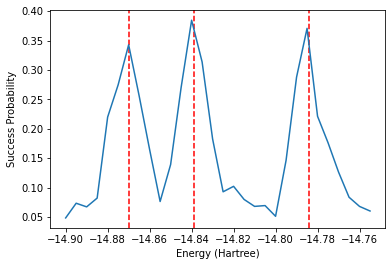

In [91]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.patch.set_facecolor('w')
ax.set_facecolor('w')
evals = [-14.8696203,  -14.83876635, -14.78403833]
for e in evals:
    ax.axvline(x=e, color='r',ls='--')
ax.plot(np.array(energies)/300-14.85, success_prob)
ax.set_xlabel('Energy (Hartree)')
ax.set_ylabel('Success Probability')

In [92]:
sim = get_backend()

sigma = 0.4

# We will use multiple reference states as probability depends on overlap with starting state.
ref_states = [vector_to_circuit(do_scbk_transform([1, 1, 0, 0], 4)),
              vector_to_circuit(do_scbk_transform([1, 0, 1, 0], 4)),
              vector_to_circuit(do_scbk_transform([0, 0, 1, 1], 4))]

# Equivalent to energies from -14.9 -> 14.75 for 10 iterations.
energies = [-0.05*300 +300*0.005*i for i in range(30)]
success_prob = list()
for energy in energies:
    success=0
    for sample in range(40):
        t = np.random.normal(0, sigma*2, 4)
        cstart = np.random.choice(ref_states)
        sv = np.zeros(2**(n_qubits+1))
        sv[0] = 1
        c_success = 1
        for i, tk in enumerate(t):
            if i == 0:
                circuit = cstart + rodeo_cycle(h_obj, energy, tk, n_qubits)
            else:
                circuit = rodeo_cycle(h_obj, energy, tk, n_qubits)
            _, sv = sim.simulate(circuit, return_statevector=True, initial_statevector=sv)
            sv = np.reshape(sv, (2, 2**n_qubits))[0, :].flatten()
            norm = np.linalg.norm(sv)
            c_success *= norm**2
            sv /= norm
            sv = np.kron([1,0], sv)
            
        #print(sim.mid_circuit_meas_freqs)
        success += c_success
    success_prob.append(success/40)
    print(energy, success/40)


-15.0 0.052744887303785126
-13.5 0.06840914543044617
-12.0 0.04426364818220732
-10.5 0.06969755397279226
-9.0 0.13294498037461394
-7.5 0.14978473448633142
-6.0 0.20779865063867256
-4.5 0.11236945555505569
-3.0 0.08480389019554127
-1.5 0.08064271882033727
0.0 0.0900282394439046
1.5 0.1611992745799951
3.0 0.33039632626671045
4.5 0.1553221321999903
6.0 0.0840167640156647
7.5 0.07462180963250899
9.0 0.0653879880311874
10.5 0.05566018510055919
12.0 0.057519541042564945
13.5 0.04244799700232067
15.0 0.039787242159317726
16.5 0.08059966684468595
18.0 0.10639574861778231
19.5 0.3203878571022366
21.0 0.17553587807290577
22.5 0.06467122967550196
24.0 0.06662351850850465
25.5 0.04148758540615636
27.0 0.06482142056498312
28.5 0.05286575020774845


Text(0, 0.5, 'Success Probability')

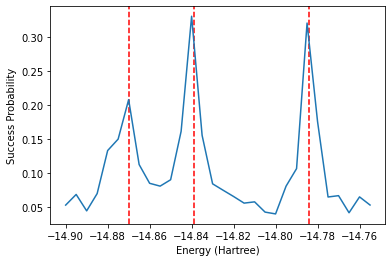

In [93]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.patch.set_facecolor('w')
ax.set_facecolor('w')
evals = [-14.8696203,  -14.83876635, -14.78403833]
for e in evals:
    ax.axvline(x=e, color='r',ls='--')
ax.plot(np.array(energies)/300-14.85, success_prob)
ax.set_xlabel('Energy (Hartree)')
ax.set_ylabel('Success Probability')

In [96]:
from openfermion import get_ground_state, get_sparse_operator
h_obj =  f2q_mapping(mol_Li2.fermionic_hamiltonian, "scbk", mol_Li2.n_active_sos,
                     mol_Li2.n_active_electrons, up_then_down=True, spin=mol_Li2.spin)
e_ground, v_ground = get_ground_state(get_sparse_operator(h_obj))
h_obj = 300*(h_obj - QubitOperator((), -14.85))

-14.869620303779788


Using exact energy

In [127]:
success_prob = list()
energies = [e_ground/300-14.85]

# Need larger time evolution
for energy in energies:
    success=0
    for sample in range(5):
        t = np.random.normal(0, sigma*20, 10)
        cstart = ref_states[1]
        sv = np.zeros(2**(n_qubits+1))
        sv[0] = 1
        c_success = 1
        ttime = 0
        for i, tk in enumerate(t):
            ttime += abs(tk)
            if i == 0:
                circuit = cstart + rodeo_cycle(h_obj, energy, tk, n_qubits)
            else:
                circuit = rodeo_cycle(h_obj, energy, tk, n_qubits)
            _, sv = sim.simulate(circuit, return_statevector=True, initial_statevector=sv)
            sv = np.reshape(sv, (2, 2**n_qubits))[0, :].flatten()
            norm = np.linalg.norm(sv)
            c_success *= norm**2
            sv /= norm
            if i != 9:
                sv = np.kron([1,0], sv)
            else:
                sv = np.reshape(sv, [2,2]).T.flatten()
                c_overlap = np.abs(np.dot(sv, v_ground))
                print(f'Using time evolution of {ttime}')
                print(f'success probability = {c_success} with overlap to exact wavefunction {c_overlap}')

Using time evolution of 65.7688995623693
success probability = 0.857722777659342 with overlap to exact wavefunction 0.9999998177601798
Using time evolution of 56.974783999623284
success probability = 0.8628847710215928 with overlap to exact wavefunction 0.9999997438211412
Using time evolution of 73.62290174725581
success probability = 0.8376764940323227 with overlap to exact wavefunction 0.999999991695909
Using time evolution of 68.97836920071144
success probability = 0.8546929335832387 with overlap to exact wavefunction 0.999999981758423
Using time evolution of 41.54138146345455
success probability = 0.9288647086354455 with overlap to exact wavefunction 0.9995315400223259
